# 实验3 Logistic回归
    
【高校录取预测】：根据申请学生的两门课程成绩预测是否被录取

In [249]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op

## 1. 数据准备
### 1.1 读取数据

In [250]:
data = np.loadtxt('./ex3data.txt', delimiter=',')
X = data[:,0:2]
y = data[:,-1]
m, n = X.shape

### 1.2 绘制散点图

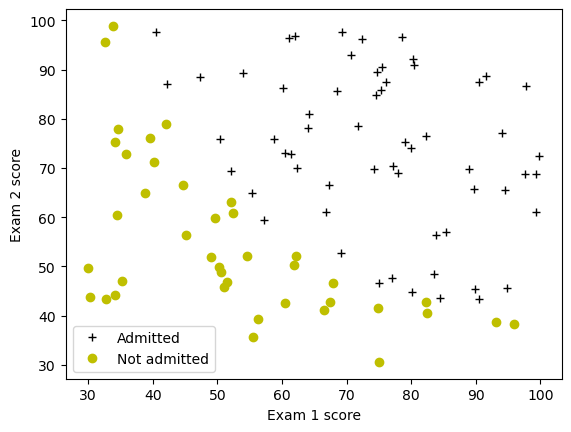

In [251]:
pos = X[data[:,2]==1,:]
neg = X[data[:,2]==0,:]
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.plot(pos[:,0], pos[:,1], '+k', label='Admitted') # 绘制正例
plt.plot(neg[:,0], neg[:,1], 'oy', label='Not admitted') # 绘制负例
plt.legend()
plt.show()


### 1.3 数据预处理
1、为输入数据X加全1列（X0）

2、X、y做好转置

In [252]:
X = np.hstack((np.ones((m,1)),X)) #数组拼接方法可使用np.hstack或np.append
y = data[:, [2]].T

## 2. 实现基于交叉熵的损失函数

### 2.1 定义Sigmoid函数

In [253]:
def sigmoid(z):
    g =  1.0/(1 + np.exp(-z))    # 使用np.exp()进行自然指数运算
    return g

print(sigmoid(0), sigmoid(-100),sigmoid(10))
tmp = np.array([-5, -2, 0, 1, 3])
print(sigmoid(tmp))


0.5 3.7200759760208356e-44 0.9999546021312976
[0.00669285 0.11920292 0.5        0.73105858 0.95257413]


### 2.2 实现损失函数、梯度

In [254]:
# 因为代价函数和梯度需要提供给SciPy的最小化函数
# 按照最小化函数参数的要求，代价和梯度需要使用flatten()转为一维数组
def costFunction(w, X, y):
    fx = sigmoid(X @ w)
    fx = np.clip(fx, 1e-15, 1 - 1e-15)
    cost = (-y @ np.log(fx) - (1 - y) @ np.log(1 - fx)) / m            # 使用np.log()计算对数。
    return cost

def gradient(w, X, y):
    fx = sigmoid(X @ w)
    grad = (X.T @ (fx - y.T)) / m
    return grad.flatten() # 返回一维数组

w = np.zeros((n + 1,1))
[cost, grad] = [costFunction(w, X, y),gradient(w, X, y)]
print('costFunction()应该为0.6931')
print('gradient()结果应该为[-0.1, -12.0092, -11.2628]')
print('对初始零向量w求得的cost为',cost,'\n梯度为',grad)


costFunction()应该为0.6931
gradient()结果应该为[-0.1, -12.0092, -11.2628]
对初始零向量w求得的cost为 [[0.69314718]] 
梯度为 [ -0.1        -12.00921659 -11.26284221]


对非零向量w进行测试

In [255]:
test_w = np.array([-24, 0.2, 0.2]).T.reshape(3,1)
[test_cost, test_grad] = [costFunction(test_w, X, y),gradient(test_w, X, y)]
print('costFunction()应返回0.2183')
print('gradient()结果应该为[0.0429, 2.566, 2.6468]')
print('对非零向量w[-24, 0.2, 0.2]求得的cost为',test_cost,'梯度为\n',test_grad)


costFunction()应返回0.2183
gradient()结果应该为[0.0429, 2.566, 2.6468]
对非零向量w[-24, 0.2, 0.2]求得的cost为 [[0.21833019]] 梯度为
 [0.04290299 2.56623412 2.64679737]


### 2.3 使用scipy.optimize.minimize()最小化损失函数

在Python中使用SciPy包下的scipy.optimize.minimize方法的TNC(Truncated Newton方法)最小化代价函数

minimize()函数参数x0与jac的返回值类型必须为一维数组，请确
认cost和gradient使用flatten()将其转成一维数组的副本

In [256]:
# 验证参数维度是否正确 grad, w.flatten(), X ,y.flatten()
print(np.shape(grad),np.shape(w.flatten()),np.shape(X),np.shape(y.flatten()))

(3,) (3,) (100, 3) (100,)


In [257]:
result = op.minimize(fun=costFunction, x0=w.flatten(), args=(X, y.flatten()), method='CG', jac=gradient)
print(result)
min_w = result.x
print(min_w)

     fun: 0.20349770161759173
     jac: array([ 1.29376656e-07, -2.43893086e-09, -1.20432888e-09])
 message: 'Optimization terminated successfully.'
    nfev: 100
     nit: 41
    njev: 100
  status: 0
 success: True
       x: array([-25.16089847,   0.20622823,   0.20146808])
[-25.16089847   0.20622823   0.20146808]


### 2.4 使用Logistic回归模型进行预测

#### 2.4.1 绘制决策边界曲线

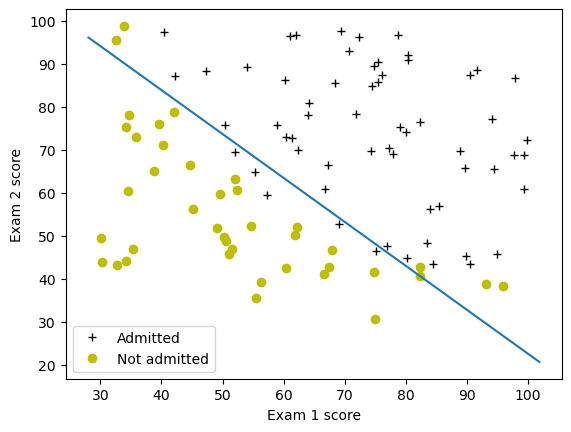

In [258]:
# 此时X是100*3的二维数组，两门考试成绩的ID分别是1和2
pos = data[data[:,2] == 1, 0:2 ]
neg = data[data[:,2] == 0, 0:2 ]
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.plot(pos[:,0], pos[:,1], '+k', label='Admitted') # 绘制正例
plt.plot(neg[:,0], neg[:,1], 'oy', label='Not admitted') # 绘制负例
plt.legend()

pred_x = [np.min(X[:,[1]])-2,np.max(X[:,[1]])+2]
pred_y = (min_w[0]+np.dot(pred_x,min_w[1]))/(-min_w[2])
plt.plot(pred_x, pred_y)
plt.show()

#### 2.4.2 使用Logistic回归模型进行分类预测
某考生在考试1中得45分，在考试2中得85分。用训练得到的min_w，预测该生被录取的可能

In [259]:
score = np.array([1, 45, 85])
prob = sigmoid(np.dot(score, min_w)) # 此处score和min_w都是一维数组。

print('输出结果应为0.776')
print('预测被录取的可能性为',prob)

输出结果应为0.776
预测被录取的可能性为 0.7762870853580549


#### 2.4.3 在训练数据集上计算准确率

In [260]:
def predict(w, X):
    admitRslt = np.zeros((m,1))
    z = np.dot(w, X.T)
    pos = np.where(z >= 0)
    neg = (z < 0)
    admitRslt[pos] = 1
    return admitRslt

admit = predict(min_w, X)
print('在训练数据集上的预测准确率为：', np.mean(admit == y.T)*100, '%')

在训练数据集上的预测准确率为： 89.0 %
